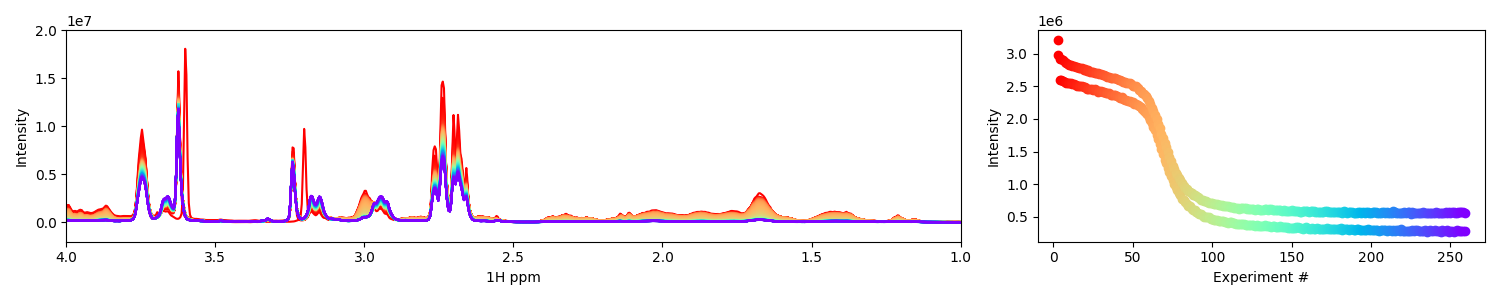

In [2]:
#analyze_1D_NMRdata.ipynb by LM Tuttle 11oct2023
#!pip install ipympl
#%matplotlib
%matplotlib widget 
#to enable an interactive plot mode, must have ipympl
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import os


GLUE = False #use nmrglue module to directly read in *.ft, if false use csv

#project_dir = '/home/tuttle/data/nmrdata/hannah/190802_Tau4RD/'
project_dir = '/home/tuttle/data/nmrdata/Mia/231006_1D_taupP'
#user_exps = ['101'] #specify exps as list ['1', '2', '5']
#user_exps = [str(x) for x in range(1,5)] #specify range of experiments to analyze
user_exps = [str(x) for x in range(3,260,1)] # e.g. can choose every 5th experiment (goes from 5 to 100, increment by 5)
use_ppms = [1.67, 3.0] #values to plot Intensity vs time

if GLUE:
    # #!pip install nmrglue #may need to install the package first
    import nmrglue as ng

def get_ng_data(proj_dir):
    dic, data = ng.pipe.read(os.path.join(proj_dir,"test.ft1"))
    data = ng.proc_base.di(data)                # discard the imaginaries

    xlabel = dic["FDF2LABEL"]+" ppm"

    uc = ng.pipe.make_uc(dic, data)
    ppm_scale = uc.ppm_scale()

    df_data = pd.DataFrame({xlabel: ppm_scale, 'Intensity':data})

    return df_data

def get_csv_data(proj_dir): #going to assume file name is test_1D.txt will need to update
    '''
    assumes only one spectrum in the ascii text file, columns will be ppm, intensity
    '''
    df_data = pd.read_csv(os.path.join(proj_dir,"test_1D.txt"),header=None,delim_whitespace=True,names=['1H ppm','Intensity'])
    return df_data

def get_ppm_index(value, df, colname):
    '''
    finds the index of the ppm entry closest to value
    '''
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        loweridx = df[df[colname] < value][colname].idxmax()
        upperidx = df[df[colname] > value][colname].idxmin()
        low_diff = abs(df[colname].iloc[loweridx] - value)
        upper_diff = abs(df[colname].iloc[upperidx] - value)
        if low_diff < upper_diff: return loweridx
        else: return upperidx

def get_Intensity(value, df, colname):
    '''
    simple linear interpolation between closest ppm in spectrum
    '''
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return df['Intensity'].iloc[exactmatch.index]
    else:
        loweridx = df[df[colname] < value][colname].idxmax()
        upperidx = df[df[colname] > value][colname].idxmin()
        xa = df[colname].iloc[loweridx]
        xb = df[colname].iloc[upperidx]
        ya = df['Intensity'].iloc[loweridx]
        yb = df['Intensity'].iloc[upperidx]
        y = ya + (yb - ya) * (value - xa)/(xb - xa)
        return y


exp_dirs = [os.path.split(f)[-1] for f in os.scandir(os.path.join(project_dir)) if f.is_dir()]
exps = exp_dirs
if (user_exps[0].lower() != 'all'): 
    check = all(item in exp_dirs for item in user_exps)
    if not check:             
        missing = list(set(user_exps)-set(exp_dirs))
        remaining = list(set(user_exps)-set(missing))
        print("missing fasta files for: ", *list(set(user_exps)-set(exp_dirs)))      
        exps = [o for o in user_exps if o in remaining]
        if len(exp_dirs): print("only processing",*exp_dirs)
    else: exps = user_exps
#print(exps)

color = iter(cm.rainbow(np.linspace(1,0,len(exps))))

fig, ax = plt.subplots(1,2,figsize=(15, 3), gridspec_kw={'width_ratios':[2,1]} )
intensity_vs_time = pd.DataFrame()
row = []
for exp in exps:
    row = [exp]
    c = next(color)
    edir = os.path.join(project_dir,exp)
    if GLUE: spectrum = get_ng_data(edir)
    else: spectrum = get_csv_data(edir)
    columns = spectrum.columns

    spectrum.plot(x=columns[0],y='Intensity',ax=ax[0], c=c)
    ax[0].get_legend().remove()
    ax[0].set_xlim(spectrum[columns[0]].max(),spectrum[columns[0]].min())
    ax[0].set_xlim(4,1)
    ax[0].set_ylim(-2e6,2e7)
    ax[0].set_ylabel("Intensity")

    for ppm in use_ppms:
        x=int(exp)
        y=get_Intensity(ppm,spectrum,columns[0])

        header = str(ppm)+"Intensity"
        row += [y]
    
        ax[1].scatter(x=x,y=y, color=c,)
    intensity_vs_time = pd.concat([intensity_vs_time,pd.Series(row)],axis=1,ignore_index=True)
    ax[1].set_xlabel("Experiment #")
    ax[1].set_ylabel("Intensity")
intensity_vs_time = intensity_vs_time.transpose()

column_names = ['Exp']+['Intensity at '+str(u) for u in use_ppms]
intensity_vs_time = intensity_vs_time.set_axis(column_names,axis=1)

fig.set_label("Tau + pP")
fig.tight_layout()
plt.show()

#intensity_vs_time.head()